# Required package

In [7]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import defaultdict, Counter
import numpy as np
import pickle
import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/data/preprocessed-data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [10]:
df_lyrics = pd.read_csv(f"{folder_path}/song_tokenized_lyrics.csv")
df_metadata = pd.read_csv(f"{folder_path}/song_metadata.csv")
df_genre = df_metadata.drop(columns=['artist', 'name', 'popularity', 'release_date','explicit', 'duration_ms', 'featured_artists'])
# df_genre.head()
# df_metadata.head()

df_music = pd.merge(df_genre,df_lyrics,on='spotify_id')
df_music = df_music.drop(columns=['spotify_id','Unnamed: 0'])

# drop song without lyrics
df_music = df_music[df_music['lyrics'] != '[]']
df_music.drop_duplicates(subset=['lyrics'], inplace=True)

<ipython-input-10-83722b0f6109>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music.drop_duplicates(subset=['lyrics'], inplace=True)


In [11]:
list(df_music['genre'].value_counts())[:10]
# get top 30 genre since some genre only have 1-2 songs
top_30_genres = df_music['genre'].value_counts()
# top_10_genre = top_10_genre.index[:10]
top_30_genres.iloc[0:30]

rock                 769
pop                  753
indie                532
soul                 373
alternative          297
folk                 281
hip-hop              242
acoustic             164
classic rock         159
singer-songwriter    143
electronic           131
country              126
jazz                 123
alternative rock     120
rap                  107
soundtrack           105
indie rock           101
punk                  89
hard rock             68
new wave              64
progressive rock      62
hip hop               56
blues                 52
metal                 47
emo                   45
post-punk             44
shoegaze              44
piano                 42
industrial            40
r&b                   40
Name: genre, dtype: int64

In [12]:
# get datafram only in top_10_genres
df_music_top_30 = df_music[df_music['genre'].isin(top_30_genres.index[:30])]
df_music_top_30['genre'].unique()

array(['rap', 'metal', 'hip-hop', 'singer-songwriter', 'punk',
       'classic rock', 'rock', 'pop', 'post-punk', 'alternative rock',
       'hard rock', 'electronic', 'hip hop', 'alternative', 'country',
       'industrial', 'soul', 'soundtrack', 'indie', 'emo', 'folk',
       'indie rock', 'piano', 'new wave', 'jazz', 'blues', 'r&b',
       'shoegaze', 'acoustic', 'progressive rock'], dtype=object)

In [13]:

# def tokenize(lyrics):
#     # lines = lyrics.split('\n')
#     words = word_tokenize(lyrics)
#     print(words[:100])
#     print(len(words))



# tokenize(rock[0])
# len(genre_tokenLyrics['rock'])

In [14]:
def clean_text(song):
    song = re.sub('\'m', ' am', song)
    song = re.sub('\'ve', ' have', song)
    song = re.sub('\'d ', ' would', song)
    song =re.sub('\'ll', ' will', song)
    song = re.sub('\'s', ' is', song)
    song = re.sub('\'re', ' are', song)

    song = song.lower()

    return song

genre_lyrics = defaultdict(list)

for genre, lyrics in zip(df_music_top_30['genre'], df_music_top_30['lyrics']):
    genre_lyrics[genre].append(lyrics)

rock = genre_lyrics['rock']

genre_tokenLyrics = defaultdict(list)
for genre, lyrics in genre_lyrics.items():
    tokenized_lyric = []
    for song in lyrics:
        song = clean_text(song)
        lines = song.split('\n')
        for line in lines:
            words = word_tokenize(line)
            tokenized_lyric.append(words)
    # if genre == 'rock':
    #     print(tokenized_lyric[:100])
    #     print(len(tokenized_lyric))
    genre_tokenLyrics[genre] = tokenized_lyric
genre_tokenLyrics['rock'][0]

['[', 'verse', '1', ']']

# Create DataFrame

In [15]:
def pad_sentence(sentence):
    padding_sentence = np.full(50, 'pad', dtype='U50')
    length = len(sentence)
    if length < 50:
        padding_sentence[(50-length):] = sentence
    else:
        padding_sentence = sentence[(length-50):]
    return padding_sentence

# x = ['iaaa','iaaa','iaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa','iiaaa']
# y = pad_sentence(x)
# print(y)

In [16]:
genres = []
input_lyrics = []
output_words = []

for genre, lyrics in genre_tokenLyrics.items():
    for sentence in lyrics:
        if len(sentence) > 1:
            sentence = pad_sentence(sentence)
            input_sentence = sentence[:-1]
            output_word = sentence[-1]

            genres.append(genre)
            input_lyrics.append(input_sentence)
            output_words.append(output_word)


df_music_cleaned = pd.DataFrame({
    'genre': genres,
    'input_lyrics': input_lyrics,
    'output_word': output_words
})

In [17]:
# output_words[0] in string.punctuation
output_words
len(output_words)

252365

In [18]:
x = 0
for word in output_words:
    if word in string.punctuation:
        x += 1
print(x)

61920


In [19]:
df_music_cleaned

,genre,input_lyrics,output_word
0,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
1,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",tired
2,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",left
3,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",weak
4,rap,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",left
...,...,...,...
252360,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",me
252361,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",phone
252362,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",]
252363,progressive rock,"[pad, pad, pad, pad, pad, pad, pad, pad, pad, ...",ho-ho-home


# DataSet

In [20]:
word_counts = Counter()
for _, tokenLyric in genre_tokenLyrics.items():
    for song in tokenLyric:
        word_counts.update(song)
    words = list(word_counts.keys())
    word_to_index = {w: idx for idx, w in enumerate(words)}
    index_to_word = {idx: w for idx, w in enumerate(words)}

# some words can't be found in Dictionary
word_to_index["<UNK>"] = len(word_to_index)

# word_to_index
genres = genre_tokenLyrics.keys()
genre_to_index = {genre: idx for idx, genre in enumerate(genres)}
index_to_genre = {idx: genre for idx, genre in enumerate(genres)}

# genre_to_index

In [21]:
class LyricsDataset(Dataset):
    def __init__(self, dataframe, word_to_index, genre_to_index):
        self.dataframe = dataframe
        self.word_to_index = word_to_index
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        genre = self.genre_to_index[row['genre']]
        input_lyrics = [self.word_to_index.get(word, self.word_to_index["<UNK>"]) for word in row['input_lyrics']]
        output_word = self.word_to_index.get(row['output_word'], self.word_to_index["<UNK>"])
        return torch.tensor(input_lyrics, dtype=torch.long), torch.tensor(genre, dtype=torch.long), torch.tensor(output_word, dtype=torch.long)

train_dataset = LyricsDataset(df_music_cleaned, word_to_index, genre_to_index)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, genre_size, embedding_dim, hidden_dim, output_dim):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.genre_embedding = nn.Embedding(genre_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, lyrics, genre):
        lyrics_embedded = self.embedding(lyrics)
        genre_embedded = self.genre_embedding(genre)
        combined = lyrics_embedded + genre_embedded.unsqueeze(1)
        lstm_out, _ = self.lstm(combined)
        out = self.fc(lstm_out[:, -1, :])
        return out

vocab_size = len(word_to_index)
genre_size = 30
embedding_dim = 128
hidden_dim = 128
output_dim = vocab_size
model = LyricsLSTM(vocab_size, genre_size, embedding_dim, hidden_dim, output_dim).to(device)
print(model)

LyricsLSTM(
  (embedding): Embedding(31629, 128)
  (genre_embedding): Embedding(30, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=31629, bias=True)
)


100%|██████████| 3944/3944 [00:57<00:00, 68.62it/s]


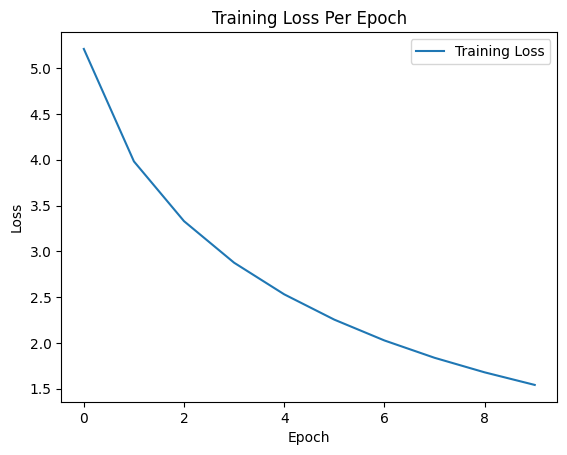

In [24]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

## Pickle model

In [25]:
with open('lyrics_model_10epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

In [89]:
# def train_model(model, train_loader, criterion, optimizer, num_epochs):
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         for lyrics, genre, target in tqdm(train_loader):
#             lyrics = lyrics.to(device)
#             genre = genre.to(device)
#             target = target.to(device)

#             optimizer.zero_grad()
#             outputs = model(lyrics, genre)
#             loss = criterion(outputs, target)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 3
# train_model(model, train_dataloader, criterion, optimizer, num_epochs)


## epoch 20

100%|██████████| 3944/3944 [00:57<00:00, 68.21it/s]


Epoch 1/20, Loss: 5.1729


100%|██████████| 3944/3944 [00:59<00:00, 66.15it/s]


Epoch 2/20, Loss: 3.9517


100%|██████████| 3944/3944 [00:57<00:00, 68.72it/s]


Epoch 3/20, Loss: 3.2963


100%|██████████| 3944/3944 [00:57<00:00, 68.64it/s]


Epoch 4/20, Loss: 2.8416


100%|██████████| 3944/3944 [00:58<00:00, 67.44it/s]


Epoch 5/20, Loss: 2.4989


100%|██████████| 3944/3944 [00:58<00:00, 67.00it/s]


Epoch 6/20, Loss: 2.2263


100%|██████████| 3944/3944 [00:59<00:00, 66.71it/s]


Epoch 7/20, Loss: 2.0011


100%|██████████| 3944/3944 [00:57<00:00, 68.48it/s]


Epoch 8/20, Loss: 1.8126


100%|██████████| 3944/3944 [00:57<00:00, 68.97it/s]


Epoch 9/20, Loss: 1.6526


100%|██████████| 3944/3944 [00:58<00:00, 67.34it/s]


Epoch 10/20, Loss: 1.5165


100%|██████████| 3944/3944 [00:57<00:00, 68.36it/s]


Epoch 11/20, Loss: 1.4216


100%|██████████| 3944/3944 [00:57<00:00, 68.87it/s]


Epoch 12/20, Loss: 1.3038


100%|██████████| 3944/3944 [00:57<00:00, 68.33it/s]


Epoch 13/20, Loss: 1.2120


100%|██████████| 3944/3944 [00:58<00:00, 66.93it/s]


Epoch 14/20, Loss: 1.1298


100%|██████████| 3944/3944 [00:58<00:00, 67.89it/s]


Epoch 15/20, Loss: 1.0568


100%|██████████| 3944/3944 [00:57<00:00, 68.23it/s]


Epoch 16/20, Loss: 0.9929


100%|██████████| 3944/3944 [00:57<00:00, 69.02it/s]


Epoch 17/20, Loss: 0.9356


100%|██████████| 3944/3944 [00:57<00:00, 68.66it/s]


Epoch 18/20, Loss: 0.8841


100%|██████████| 3944/3944 [00:58<00:00, 67.54it/s]


Epoch 19/20, Loss: 0.8376


100%|██████████| 3944/3944 [00:57<00:00, 68.62it/s]


Epoch 20/20, Loss: 0.7941


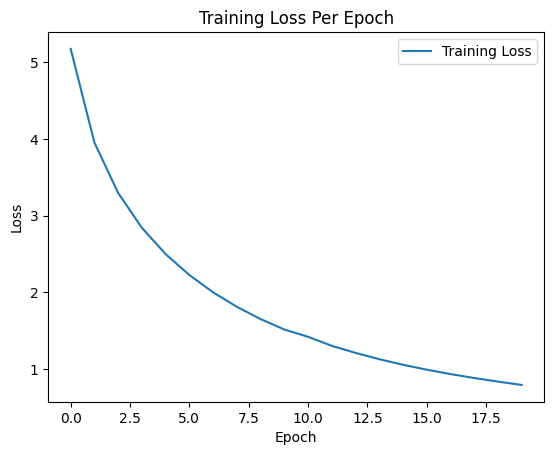

In [29]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
train_model(model, train_dataloader, criterion, optimizer, num_epochs)
with open('lyrics_model20epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

## epoch 30

100%|██████████| 3944/3944 [00:57<00:00, 68.94it/s]


Epoch 1/10, Loss: 0.8687


100%|██████████| 3944/3944 [00:58<00:00, 67.79it/s]


Epoch 2/10, Loss: 0.7618


100%|██████████| 3944/3944 [00:57<00:00, 69.13it/s]


Epoch 3/10, Loss: 0.7174


100%|██████████| 3944/3944 [00:59<00:00, 66.02it/s]


Epoch 4/10, Loss: 0.6823


100%|██████████| 3944/3944 [00:57<00:00, 68.28it/s]


Epoch 5/10, Loss: 0.6522


100%|██████████| 3944/3944 [00:58<00:00, 67.29it/s]


Epoch 6/10, Loss: 0.6264


100%|██████████| 3944/3944 [00:57<00:00, 68.90it/s]


Epoch 7/10, Loss: 0.6029


100%|██████████| 3944/3944 [01:01<00:00, 63.99it/s]


Epoch 8/10, Loss: 0.5818


100%|██████████| 3944/3944 [00:57<00:00, 68.81it/s]


Epoch 9/10, Loss: 0.5606


100%|██████████| 3944/3944 [00:57<00:00, 68.68it/s]


Epoch 10/10, Loss: 0.5442


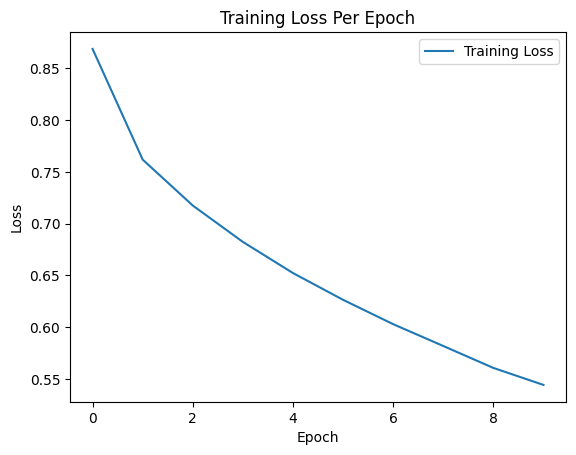

In [31]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    total_loss_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for lyrics, genre, target in tqdm(train_loader):
            lyrics = lyrics.to(device)
            genre = genre.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(lyrics, genre)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        total_loss_per_epoch.append(avg_loss)


    plt.plot(total_loss_per_epoch, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Per Epoch')
    plt.legend()
    plt.show()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_model(model, train_dataloader, criterion, optimizer, num_epochs)
with open('lyrics_model30epoch.pkl', 'wb') as f:
    pickle.dump(model, f)

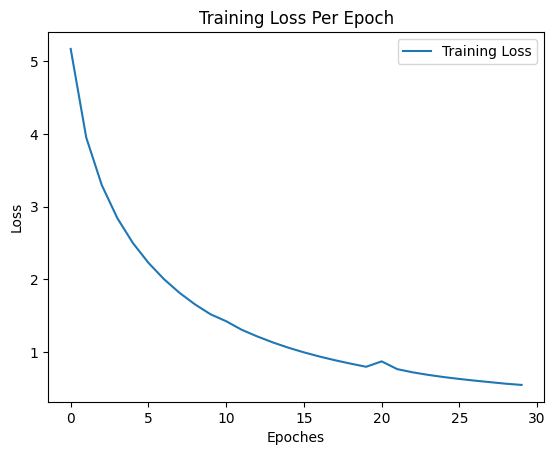

In [34]:
loss_20 = [5.1729, 3.9517, 3.2963, 2.8416, 2.4989, 2.2263, 2.0011, 1.8126, 1.6526, 1.5165, 1.4216, 1.3038, 1.2120, 1.1298, 1.0568, 0.9929, 0.9356, 0.8841, 0.8376, 0.7941]
loss_10 = [0.8687, 0.7618, 0.7174, 0.6823, 0.6522, 0.6264, 0.6029, 0.5818, 0.5606, 0.5442]
loss_30 = loss_20 + loss_10
plt.plot(loss_30, label='Training Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Training Loss Per Epoch')
plt.legend()
plt.show()

# Generator Lyrics

In [ ]:
def generate_lyrics(model, seed_text, genre, word_to_index, index_to_word, genre_to_index, max_length=50):
    model.eval()

    current_text = [word_to_index.get(word, word_to_index["<UNK>"]) for word in seed_text.split()]
    genre_index = genre_to_index[genre]

    for _ in range(max_length):
        input_seq = torch.tensor([current_text], dtype=torch.long)
        genre_seq = torch.tensor([genre_index], dtype=torch.long)

        with torch.no_grad():
            output = model(input_seq, genre_seq)
            next_word_idx = torch.argmax(output, dim=1)[-1].item()

        current_text.append(next_word_idx)
        if next_word_idx == word_to_index["</s>"]:  # 假设 "</s>" 是结束符
            break

    # 将索引转换回单词
    generated_words = [index_to_word[idx] for idx in current_text]

    return ' '.join(generated_words)

# 使用示例
seed_text = "Sun shines today"
genre = "rock"
generated_lyrics = generate_lyrics(model, seed_text, genre, word_to_index, index_to_word, genre_to_index)
print(generated_lyrics)
